# Imports

In [63]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import imp
%matplotlib inline

import sys
sys.path.insert(0, '../src/')

import network_utils

# Helper functions

In [88]:
def reload():
    imp.reload(network_utils)

# Parameters

In [22]:
weeks = 4

# Data loading

In [3]:
# Loads the csv file into a dataframe.
data = pd.read_csv('../data/Bitcoin/soc-sign-bitcoinotc.csv', header=None)

# Sets the names of the columns.
data.columns = ['source', 'target', 'weight', 'edge_date']

# Converts the datetime structure and sets in the dataframe.
converted_times = []
for row_index in range(len(data)):
    converted_times.append(
        datetime.datetime.fromtimestamp(data['edge_date'][row_index]))
data['edge_date'] = converted_times

# Sorts the data by time column.
data.sort_values(by='edge_date', inplace=True)

In [4]:
data.head()

source  target  weight                  edge_date
0       6       2       4 2010-11-08 10:45:11.728360
1       6       5       2 2010-11-08 10:45:41.533780
2       1      15       1 2010-11-08 11:05:40.390490
3       4       3       7 2010-11-08 11:41:17.369750
4      13      16       8 2010-11-08 14:10:54.447460

In [188]:
print('How many edges are given from a source to target more than once over time: ',
      len(np.where(data[['source', 'target']].duplicated())[0]))

How many edges are given from a source to target more than once over time:  0


# Data basic analysis

In [5]:
data_len = len(data)
print('Data has {} #edges.\nIt spans from {} to {}.\n'
      'It has {} #nodes (unique) in total duration.'.format(
          data_len,
          min(data['edge_date']).date(),
          max(data['edge_date']).date(),
          len(set(data['source']).union(set(data['target'])))))

pos = len(np.where(data['weight'] > 0)[0])
neg = len(np.where(data['weight'] < 0)[0])
zer = len(np.where(data['weight'] == 0)[0])  # It should not be any zeros.
print('\nEdge (trust/distrust) over time:\n\t+:'
      ' {}({}%)\n\t-: {}({}%)\n\t0: {}({}%).'.format(
          pos, round(100*pos/data_len),
          neg, round(100*neg/data_len),
          zer, round(100*zer/data_len)))

Data has 35592 #edges.
It spans from 2010-11-08 to 2016-01-24.
It has 5881 #nodes (unique) in total duration.

Edge (trust/distrust) over time:
	+: 32029(90%)
	-: 3563(10%)
	0: 0(0%).


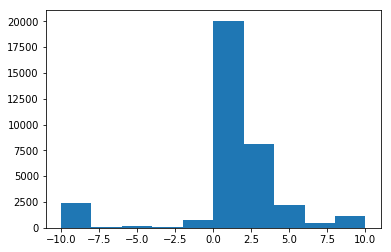

In [6]:
plt.hist(data['weight']);

# Extracting the networks

In [7]:
separate_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=False)
accumulative_dgraphs = network_utils.extract_graphs(edge_list=data, weeks=weeks, accumulative=True)

# Plotting

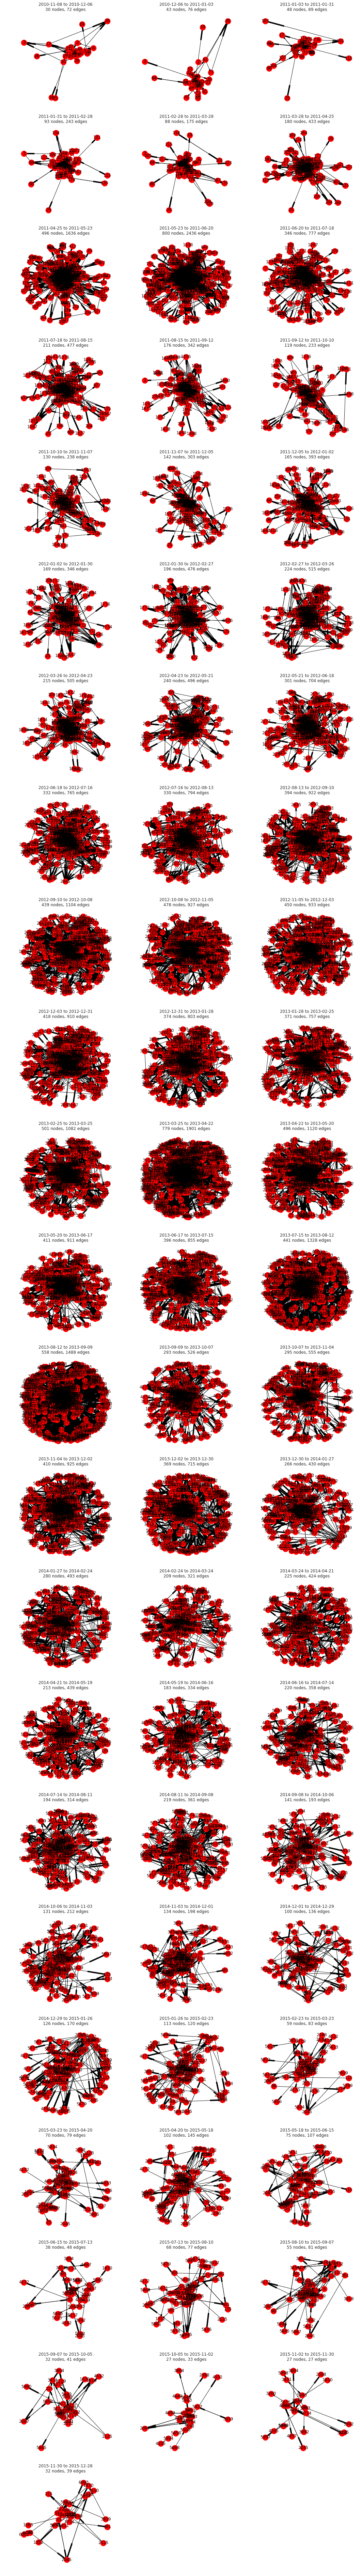

In [31]:
# Just to create title names.
title_names = []
start_date = min(data['edge_date'])
end_date = max(data['edge_date'])
periods_num = int(np.floor((end_date - start_date).days / (weeks * 7)))
for period_index in range(periods_num):
    period_start = (
        start_date + period_index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    title_names.append('{} to {}'.format(period_start.date(), period_end.date()))

network_utils.plot_evolving_graphs(dgraphs=separate_dgraphs, titles=title_names)

# Computing the metrics for networks in periods

## Metrics for separate dynamic graphs

### Goodness and fairness of nodes

In [65]:
fg_metrics = []
for dgraph in separate_dgraphs:
    fg_metrics.append(
        network_utils.compute_fairness_goodness(dgraph, verbose=False))

### All metrics

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(separate_dgraphs[0]).keys())

evolving_metrics = collections.defaultdict(list)
for index, directed_graph in enumerate(separate_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(directed_graph)
    for key in sorted_keys:
        evolving_metrics[key].append(metrics[key])

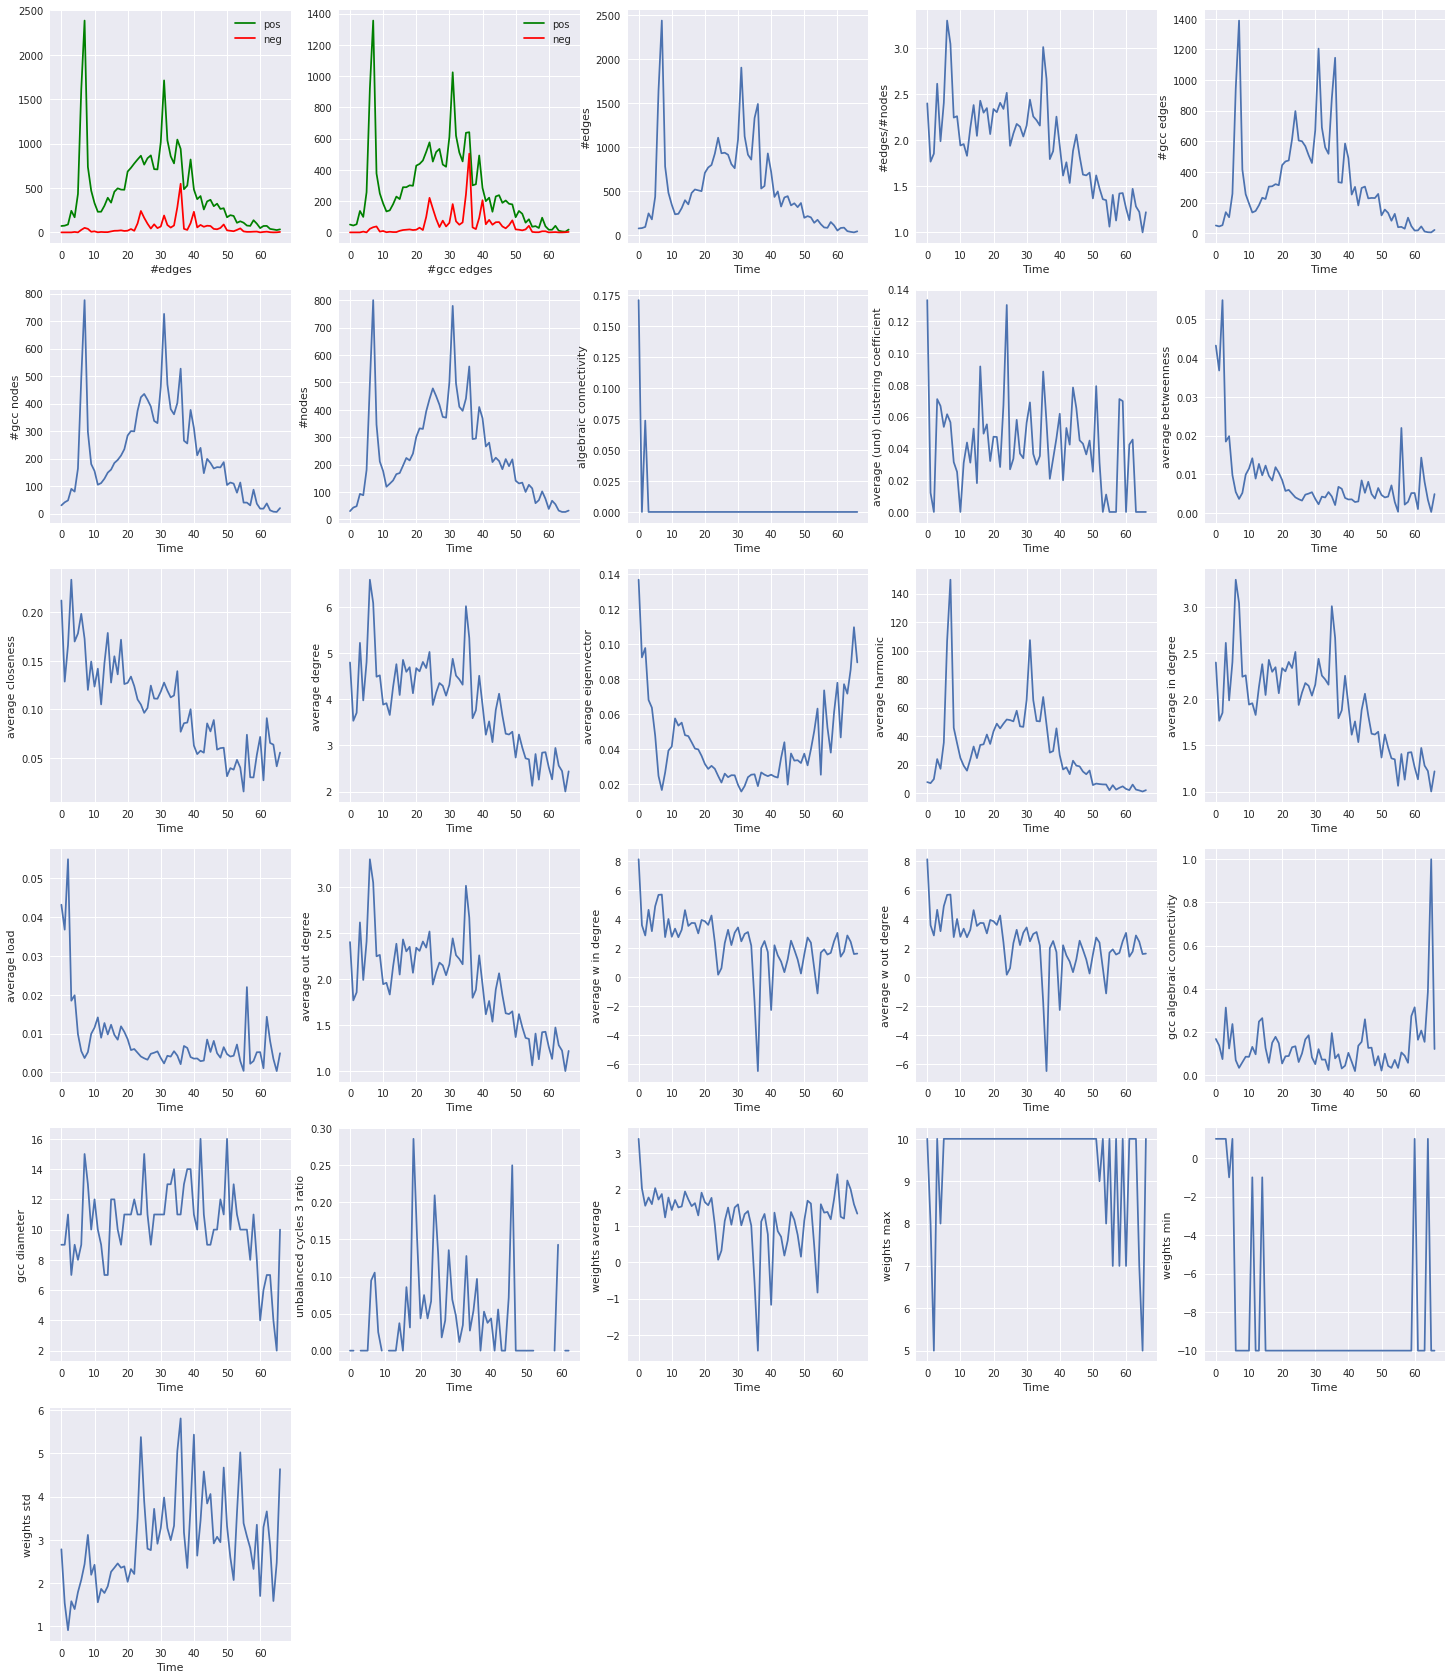

In [243]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(evolving_metrics['#pos edges'], 'g')
plt.plot(evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(evolving_metrics['#gcc pos edges'], 'g')
plt.plot(evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

### Metrics for accumulative dynamic graphs

In [ ]:
sorted_keys = sorted(
    network_utils.get_metrics_for_network(accumulative_dgraphs[0]).keys())

accumulative_evolving_metrics = collections.defaultdict(list)
for index, accumulative_dgraph in enumerate(accumulative_dgraphs):
    print(index, '...')
    metrics = network_utils.get_metrics_for_network(accumulative_dgraph)
    for key in sorted_keys:
        accumulative_evolving_metrics[key].append(metrics[key])

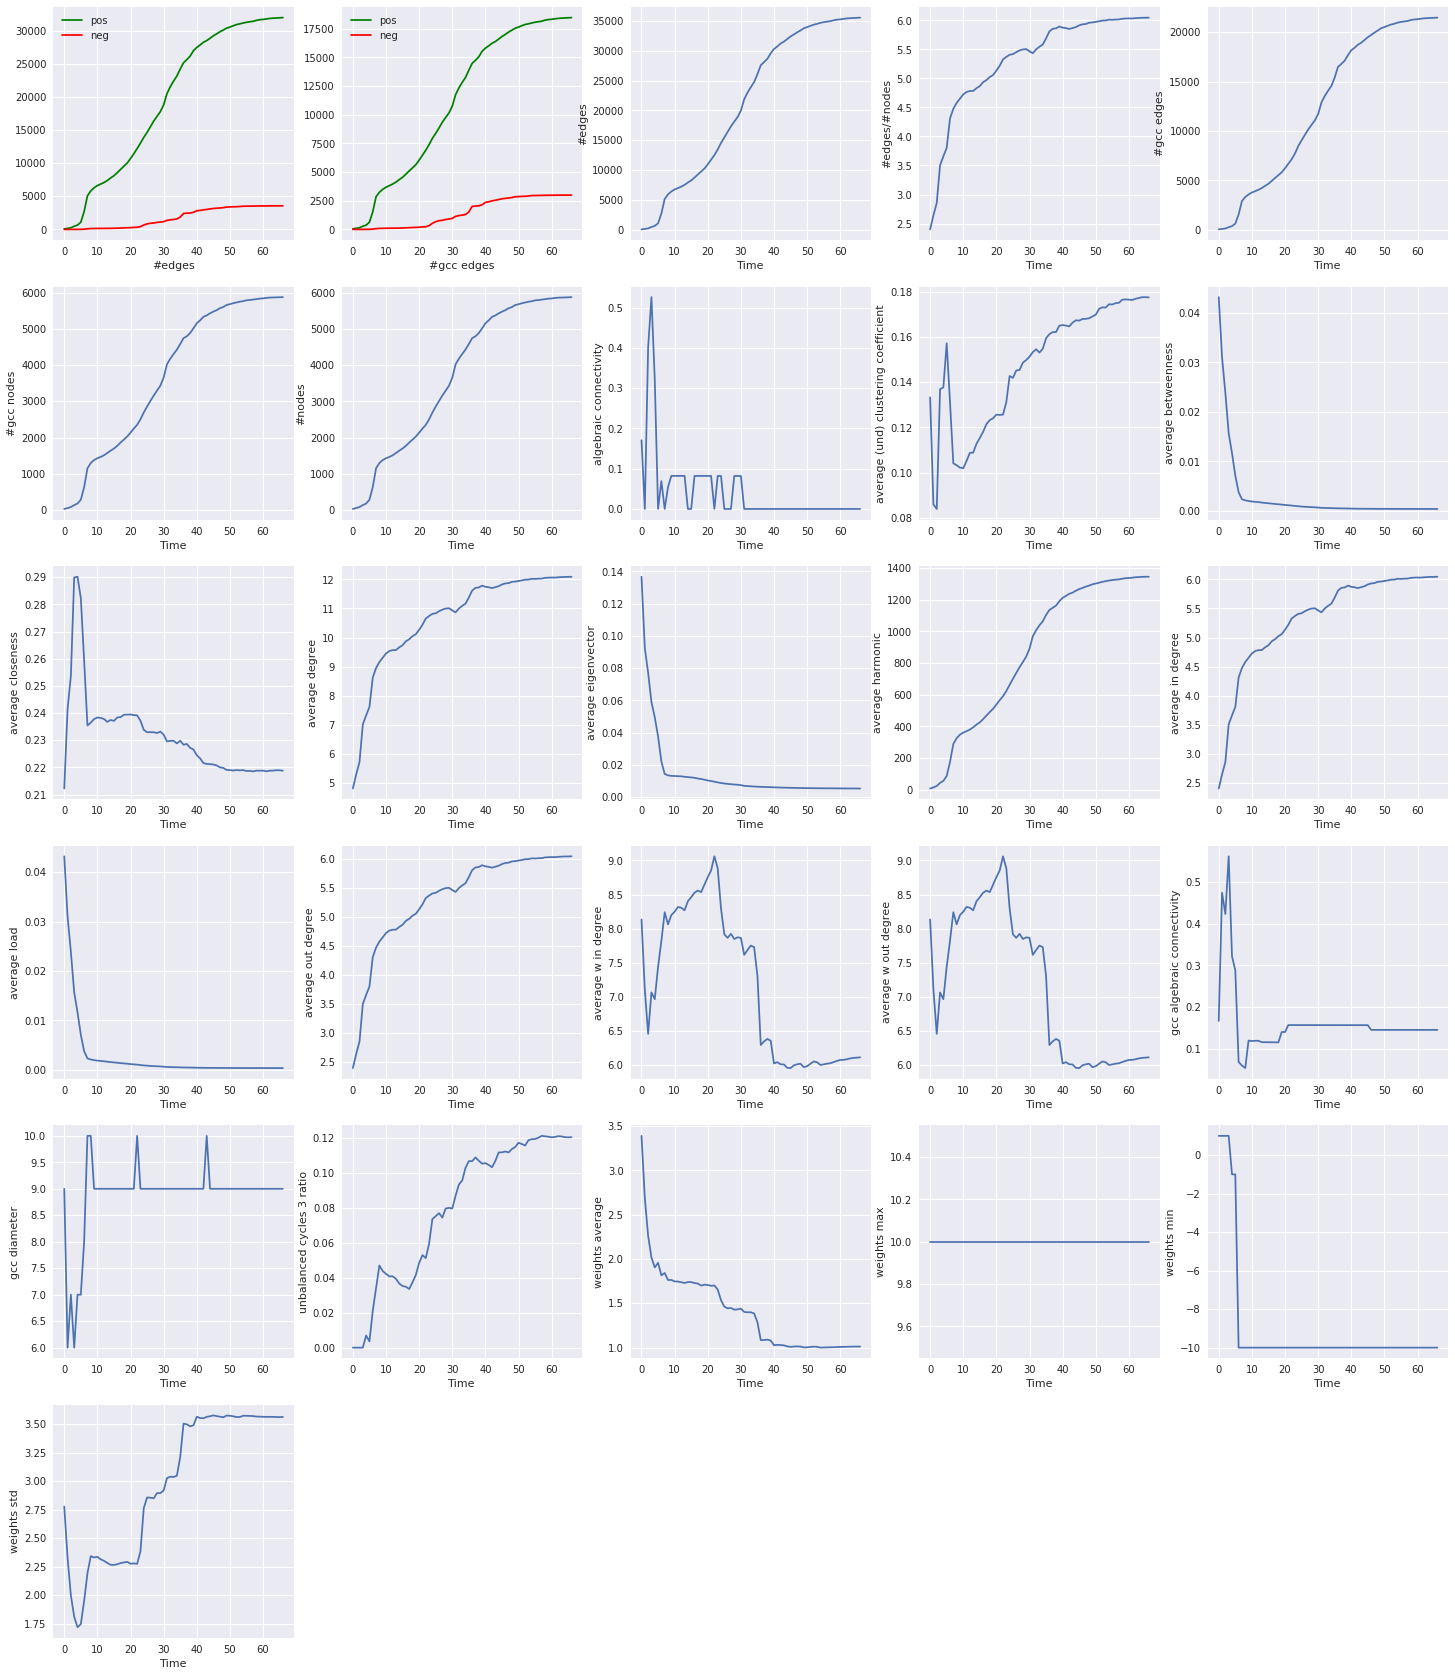

In [253]:
m = 6
n = 5
sns.set(rc={'figure.figsize':(25, 30)})

sorted_keys = sorted(list(
    set(accumulative_evolving_metrics.keys()) - set([
        '#pos edges', '#neg edges', '#gcc pos edges', '#gcc neg edges'])))

plt.subplot(m, n, 1)
plt.plot(accumulative_evolving_metrics['#pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#neg edges'], 'r')
plt.xlabel('#edges')
plt.legend(['pos', 'neg'])

plt.subplot(m, n, 2)
plt.plot(accumulative_evolving_metrics['#gcc pos edges'], 'g')
plt.plot(accumulative_evolving_metrics['#gcc neg edges'], 'r')
plt.xlabel('#gcc edges')
plt.legend(['pos', 'neg'])

for index, key in enumerate(sorted_keys):
    plt.subplot(m, n, index+3)
    plt.plot(accumulative_evolving_metrics[key])
    plt.ylabel(key)
    plt.xlabel('Time')

# Van de Rijt balance

## Separated graphs

In [169]:
edge_balances = []
for separate_dgraph in separate_dgraphs:
    edge_balances.append(
        network_utils.compute_edge_balance(separate_dgraph))

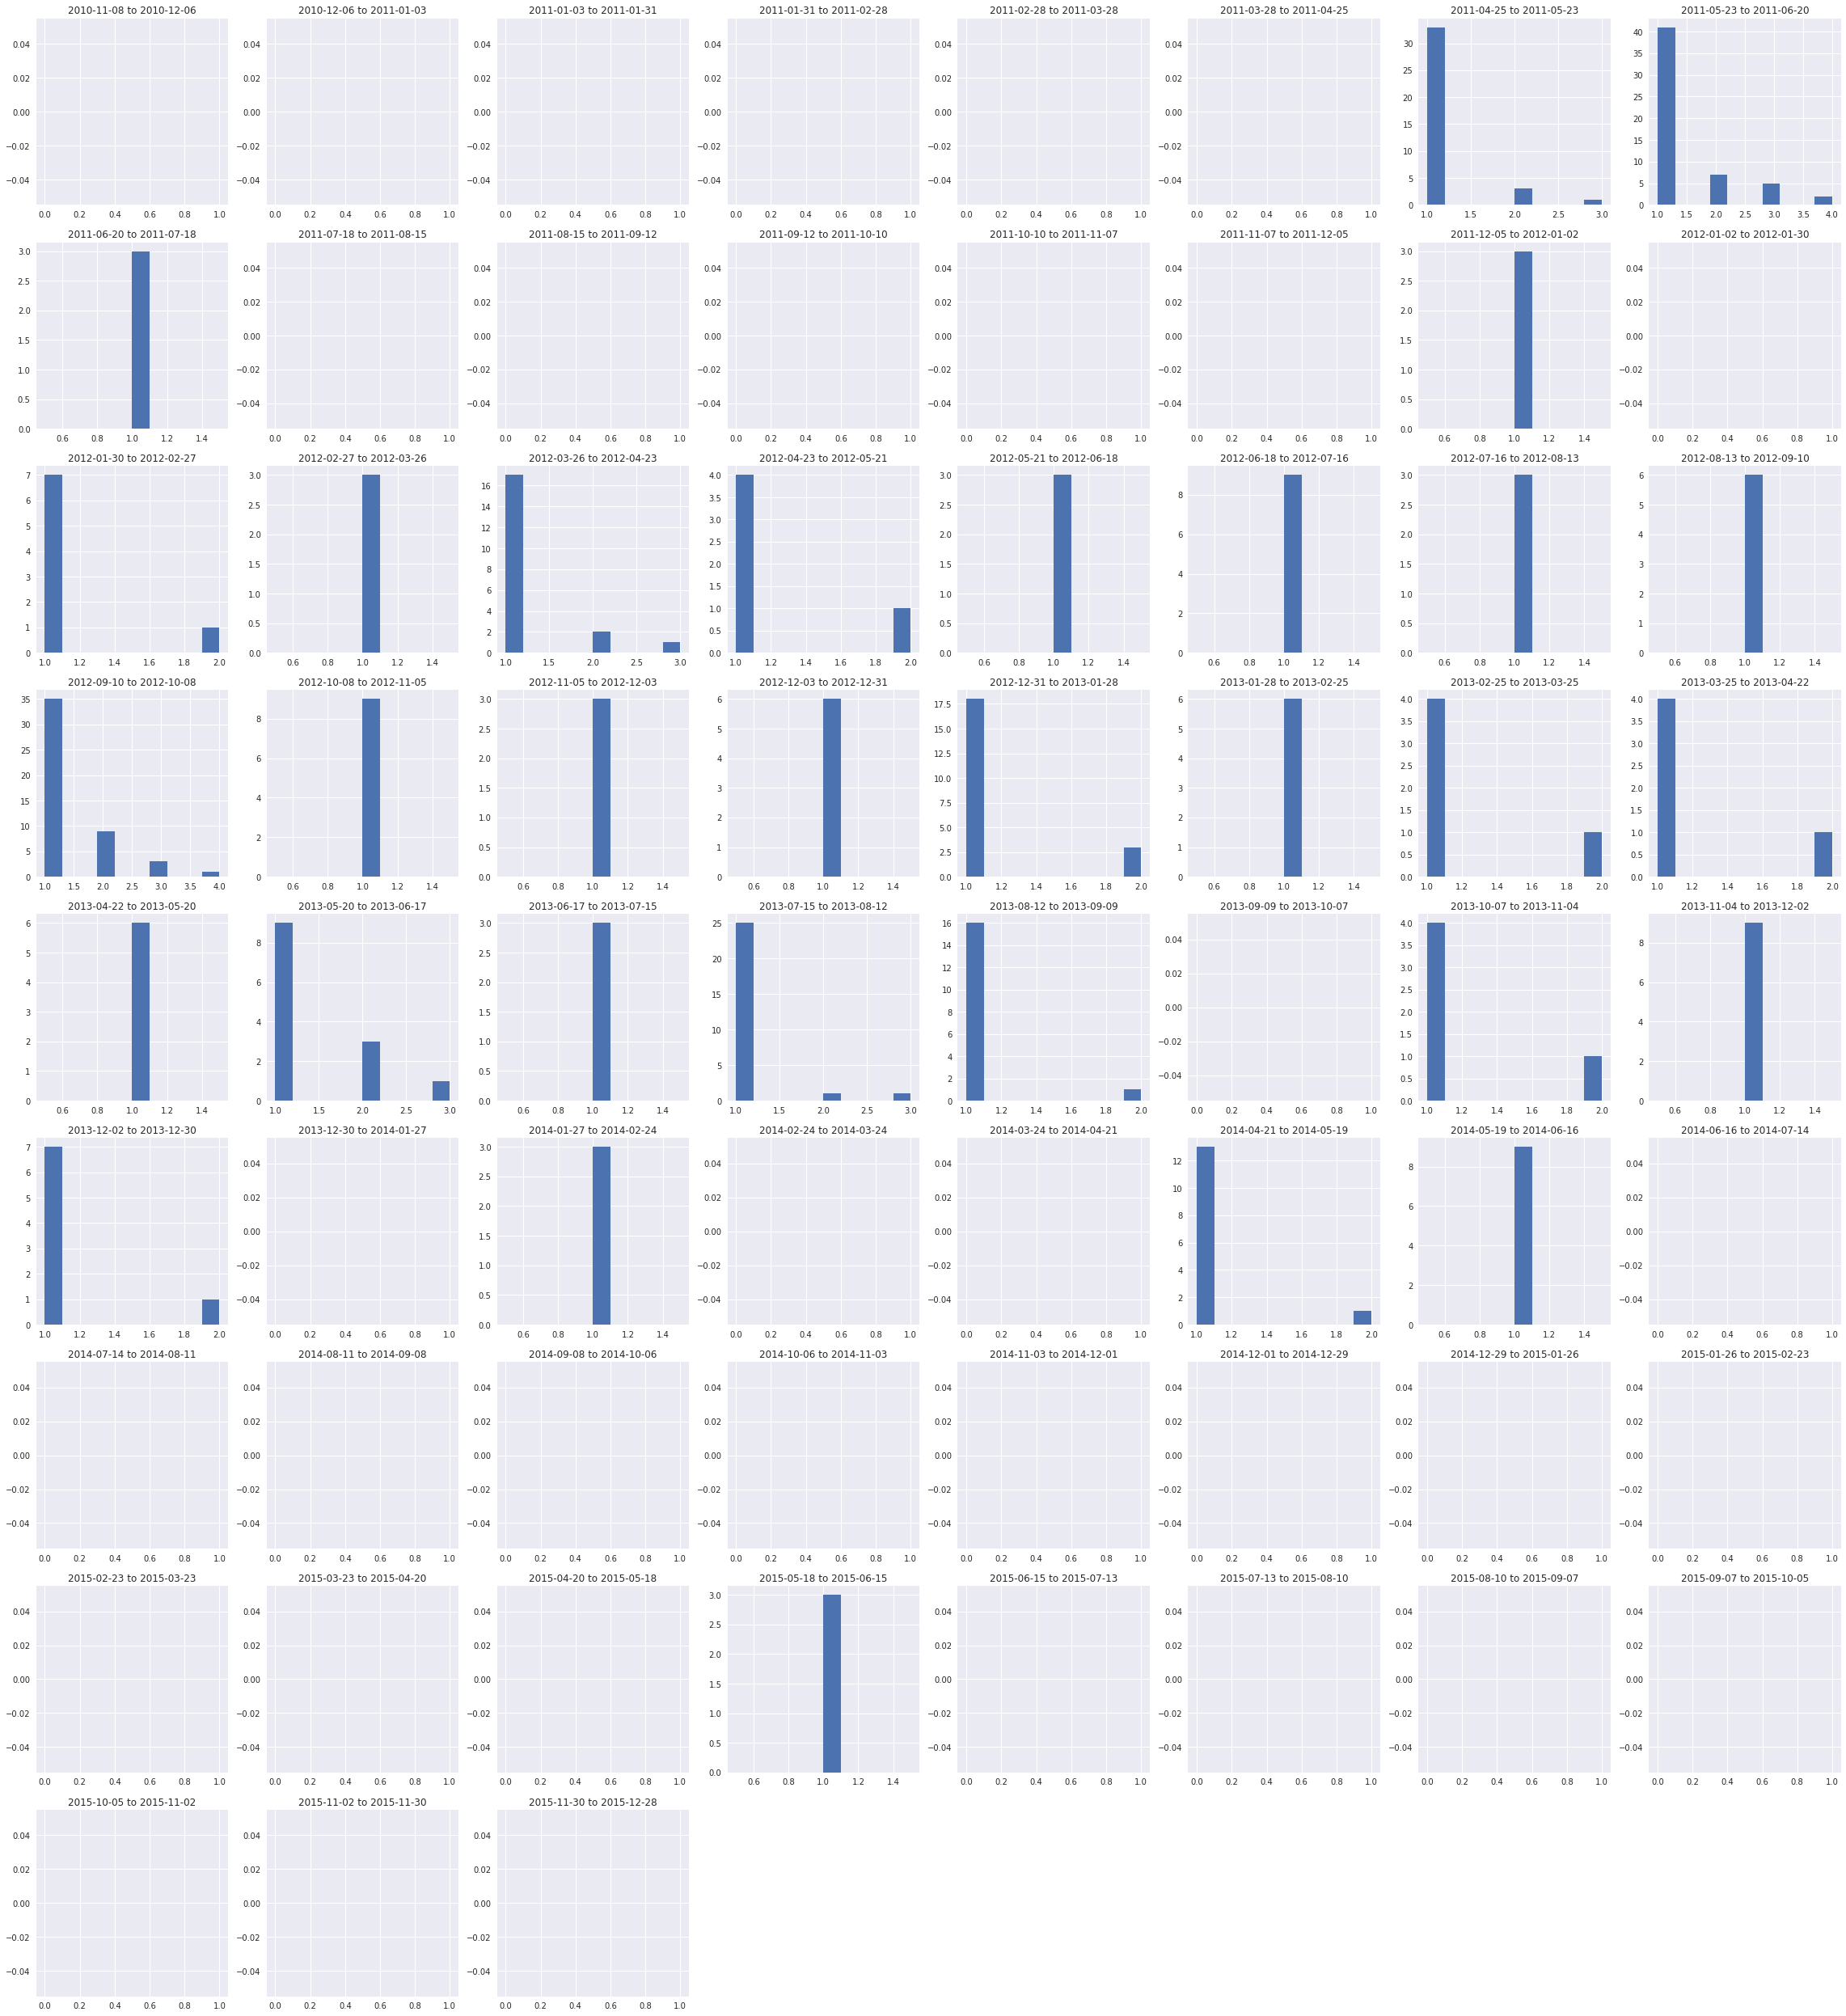

In [109]:
m = 9
n = 8
sns.set(rc={'figure.figsize':(40, 45)})
for index, edge_balance in enumerate(edge_balances):
    num_unbalanced = []
    for value in edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

## Accumulative graphs

In [ ]:
accumulative_edge_balances = []
for accumulative_dgraph in accumulative_dgraphs:
    accumulative_edge_balances.append(
        network_utils.compute_edge_balance(accumulative_dgraph))

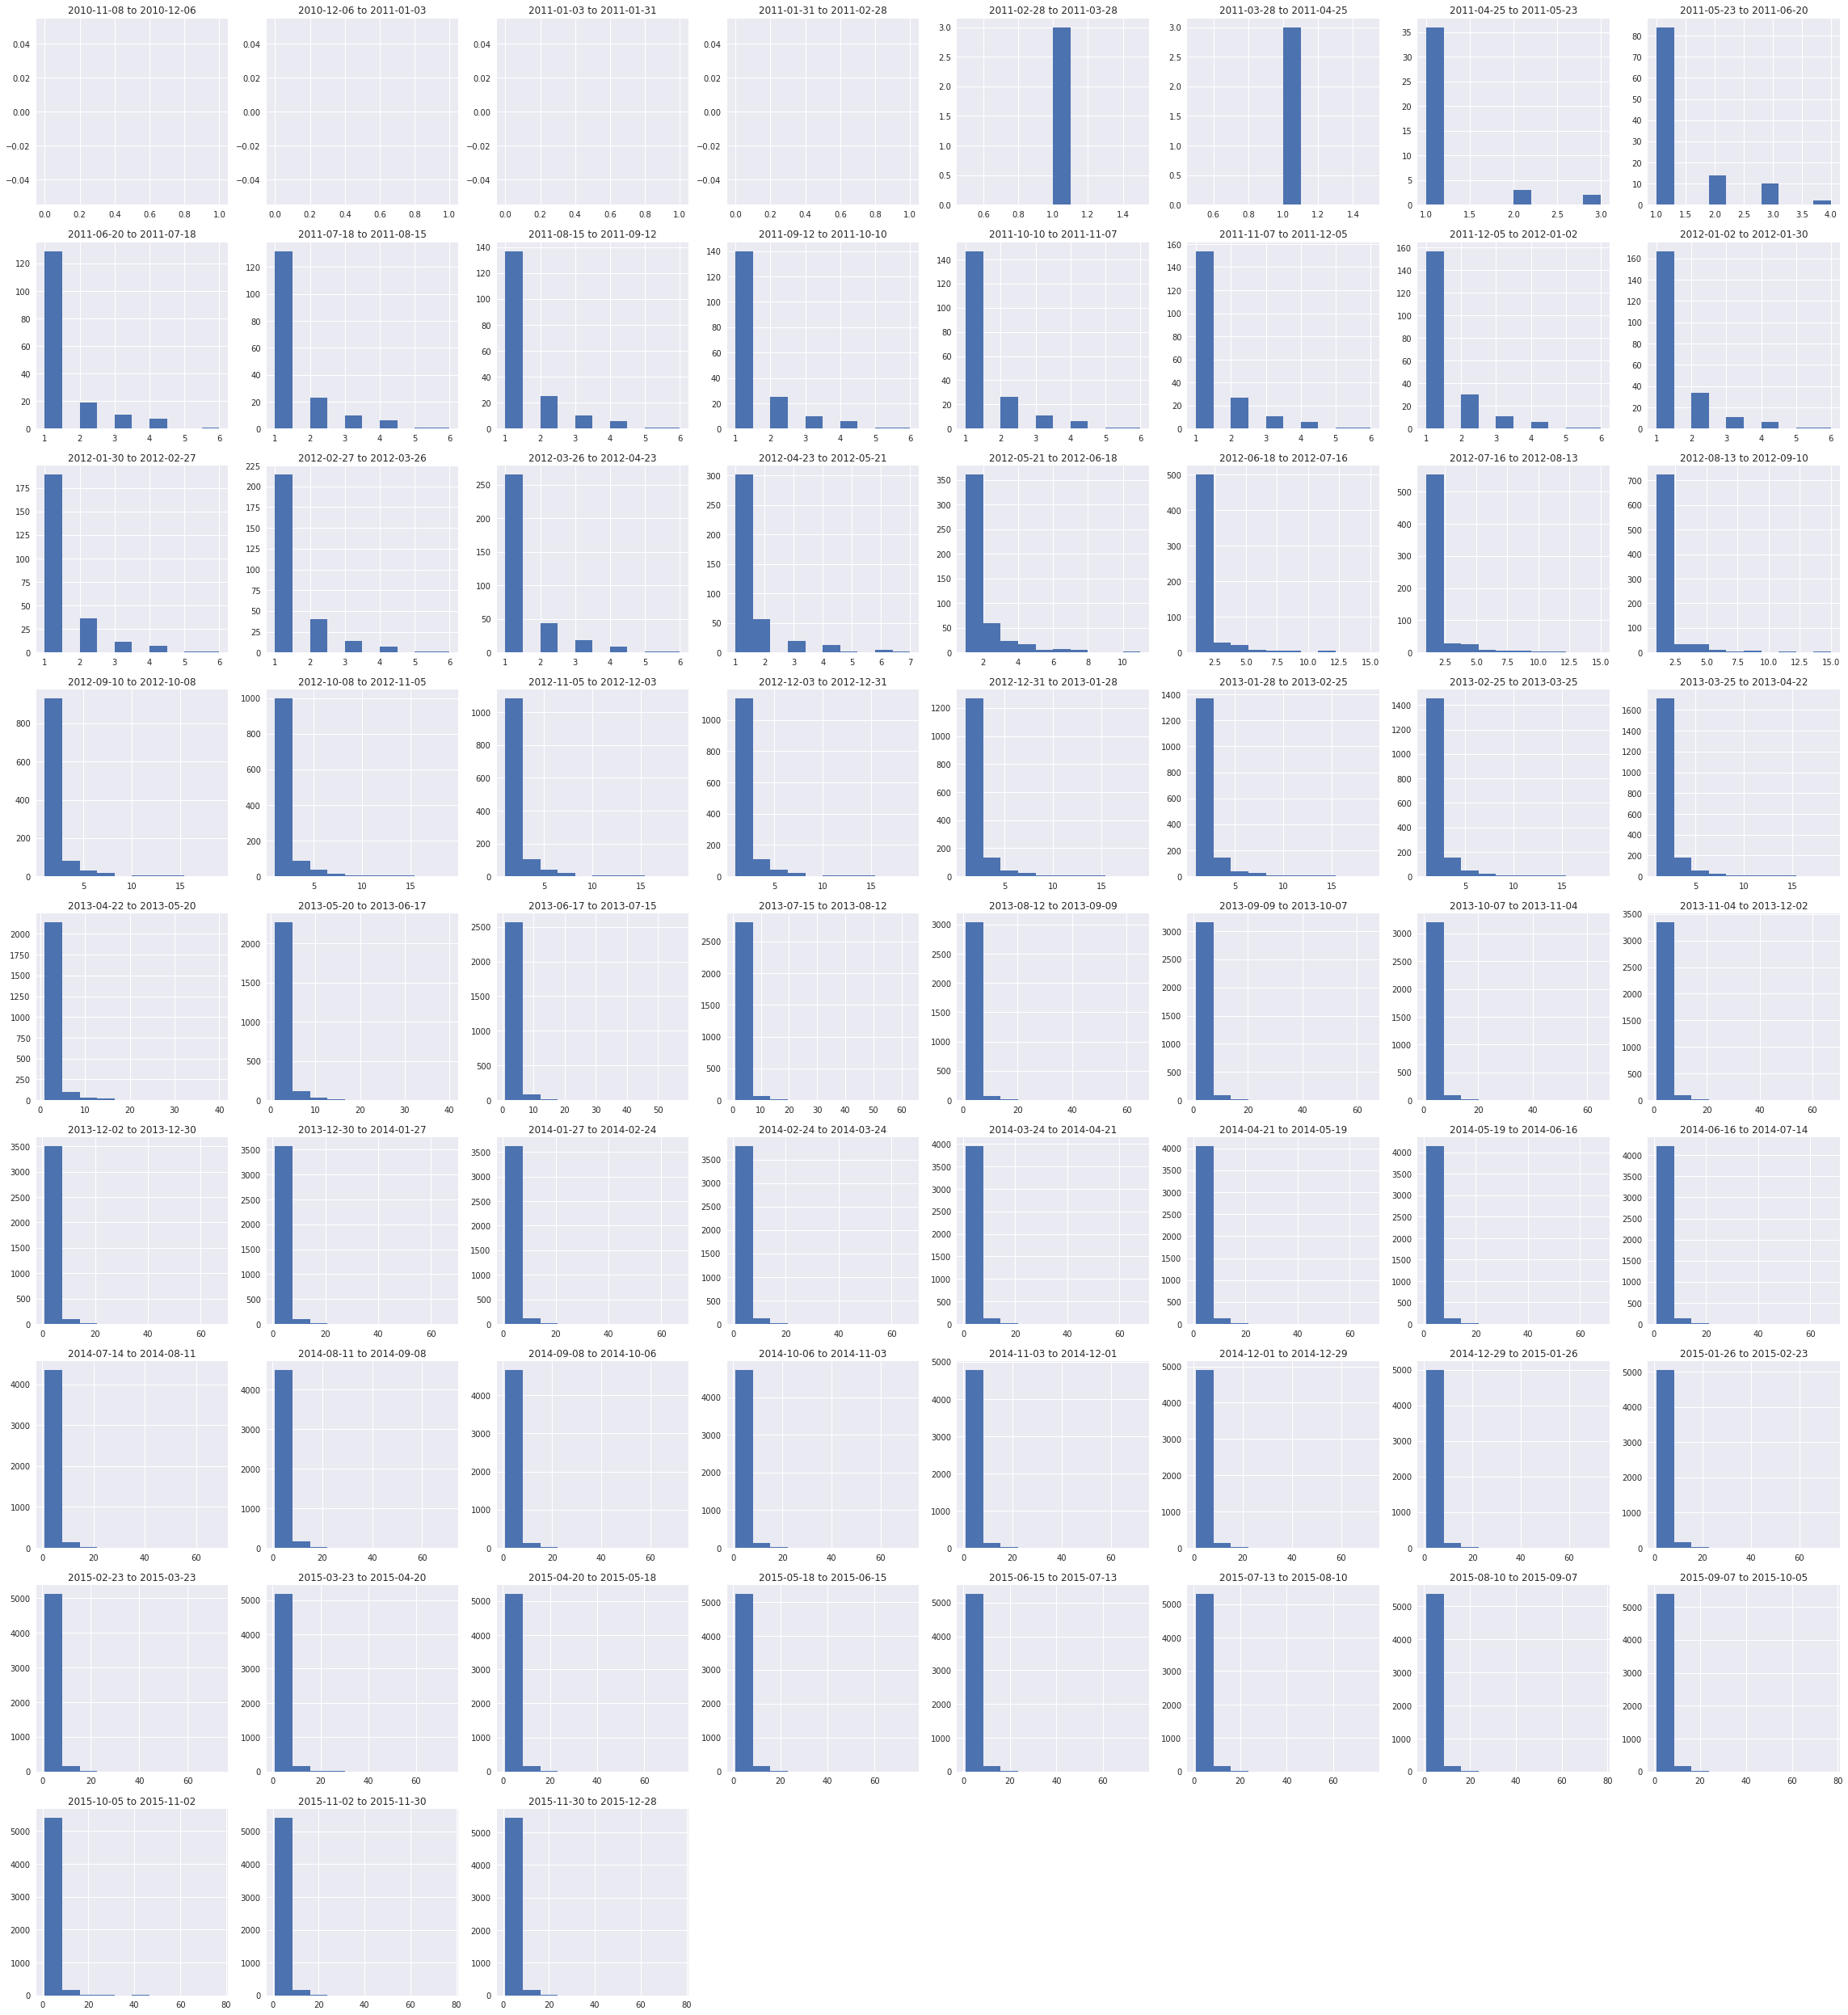

In [111]:
m = 9
n = 8
sns.set(rc={'figure.figsize':(40, 45)})
for index, accumulative_edge_balance in enumerate(accumulative_edge_balances):
    num_unbalanced = []
    for value in accumulative_edge_balance.values():
        num_unbalanced.append(
            value['#cycle3'] - value['#balanced'])
    plt.subplot(m, n, index + 1)
    if num_unbalanced:
        num_unbalanced = np.array(num_unbalanced)
        num_unbalanced = num_unbalanced[num_unbalanced.nonzero()]
    plt.hist(num_unbalanced)
    
    # Period.
    period_start = (
        start_date + index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    plt.title(
        '{} to {}'.format(str(period_start).split(' ')[0],
                          str(period_end).split(' ')[0]))

# Cartwright & Harary balance

In [112]:
# for separate_dgraph in separate_dgraphs:
#     print('cartwright & harary unbalance ratio: ',
#           network_utils.cartwright_harary_balance(separate_dgraph))